In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tvDatafeed import TvDatafeed, Interval

import pandas_ta as ta

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import datetime

In [20]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [4]:
n=1

In [121]:
tv = TvDatafeed()
def getdata(name):
    data=tv.get_hist(symbol=name,exchange='BINANCE',interval=Interval.in_daily,n_bars=5000)
    data=data.reset_index()
#     data["datetime"]=data["datetime"]+datetime.timedelta(days=1)
    data["datetime"]=data["datetime"].dt.strftime('%Y-%m-%d')
    data2=data[data["datetime"]>="2020-01-01"].copy()
    data2["datetime"] = pd.to_datetime(data2["datetime"])
    return data2

In [122]:
def getapi(api):
    response_API=requests.get(api)
    data=response_API.text
    parse_json=json.loads(data)
    df = pd.json_normalize(parse_json['values'])
    listtime=list(df['x'])
    listtime2=[]
    for i in listtime:
        listtime2.append(datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d'))
    df['datetime']=pd.Series(listtime2)
    df["datetime"] = pd.to_datetime(df["datetime"])
#     df["datetime"]=df["datetime"]+datetime.timedelta(days=1)
    df=df[df["datetime"]>="2020-01-01"].copy()
    df=df.drop(columns=['x'])
    df.rename(columns={'y':'value'},inplace=True)
    df=df.drop_duplicates(subset=['datetime'])
    return df

In [123]:
bitcoi=getdata('BTCUSDT')
eth=getdata('ETHUSDT')
bnb=getdata('BNBUSDT')
ada=getdata('ADAUSDT')
bitcoi=bitcoi[["datetime","volume","open","high","low","close"]]
bitcoi.tail(5)

,datetime,volume,open,high,low,close
1643,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86
1644,2022-02-15,28471.02342,44544.85,44549.97,43307.00,43873.56
1645,2022-02-16,47242.42931,43873.56,44164.71,40073.21,40515.70
1646,2022-02-17,43845.92241,40515.71,40959.88,39450.00,39974.44
1647,2022-02-18,17391.99591,39974.45,40444.32,39639.03,39906.93


In [124]:

number_transactions=getapi('https://api.blockchain.info/charts/n-transactions?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
number_address=getapi('https://api.blockchain.info/charts/n-unique-addresses?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=getapi('https://api.blockchain.info/charts/transactions-per-second?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
transaction_second=transaction_second.groupby(['datetime']).mean().reset_index()
total_bitcoin=getapi('https://api.blockchain.info/charts/total-bitcoins?timespan=4years&rollingAverage=24hours&format=json&sampled=true')
volume_trade=getapi('https://api.blockchain.info/charts/trade-volume?timespan=4years&rollingAverage=24hours&format=json&sampled=false')
hash_rate=getapi('https://api.blockchain.info/charts/hash-rate?timespan=4years&rollingAverage=24hours&format=json&sampled=false')

In [125]:

bitcoin=bitcoi.merge(eth[["datetime","close"]],on='datetime',how='left',suffixes=('_bitcoin', '_eth'))
bitcoin=bitcoin.merge(bnb[["datetime","close"]],on='datetime',how='left')
bitcoin=bitcoin.merge(ada[["datetime","close"]],on='datetime',how='left',suffixes=('_bnb', '_ada'))

In [126]:

data_api=number_transactions.merge(number_address,on='datetime',how='left',suffixes=('_number_transaction', '_number_address'))
data_api=data_api.merge(transaction_second,on='datetime',how='left')
data_api=data_api.merge(total_bitcoin,on='datetime',how='left',suffixes=('_transaction_second', '_total_bitcoin'))
data_api=data_api.merge(volume_trade,on='datetime',how='left')
data_api=data_api.merge(hash_rate,on='datetime',how='left',suffixes=('_volume_trade', '_hash_rate'))


In [127]:
bitcoin=bitcoin.merge(data_api,on='datetime',how='left')
bitcoin.tail(5)

,datetime,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate
775,2022-02-14,38093.46331,42535.94,44751.40,42427.03,44544.86,3183.52,432.4,1.107,273623.0,680501.0,2.481250,1.895708e+07,1.878267e+08,2.321888e+08
776,2022-02-15,28471.02342,44544.85,44549.97,43307.00,43873.56,3122.30,427.3,1.082,266788.0,677777.0,3.030208,1.895797e+07,2.354059e+08,2.069797e+08
777,2022-02-16,47242.42931,43873.56,44164.71,40073.21,40515.70,2891.87,402.4,1.020,255573.0,665429.0,3.176042,1.895885e+07,1.735183e+08,2.132565e+08
778,2022-02-17,43845.92241,40515.71,40959.88,39450.00,39974.44,2779.48,399.2,0.995,261055.0,672505.0,3.091319,1.895974e+07,3.271538e+08,1.862941e+08
779,2022-02-18,17391.99591,39974.45,40444.32,39639.03,39906.93,2735.28,397.3,0.987,NaN,NaN,NaN,NaN,NaN,NaN


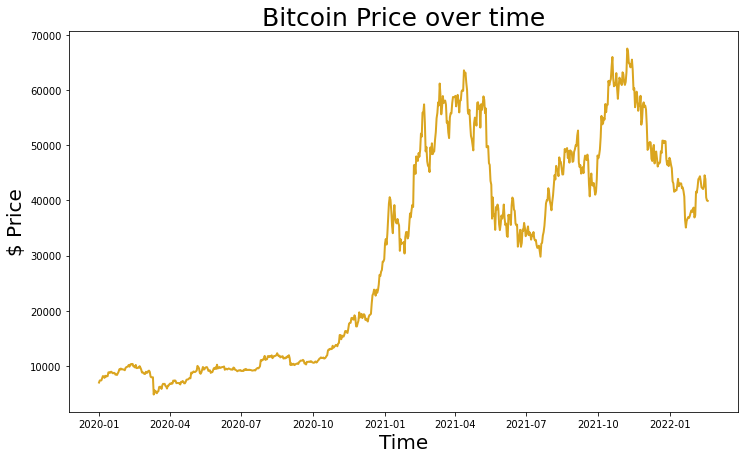

In [128]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["close_bitcoin"], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.show()

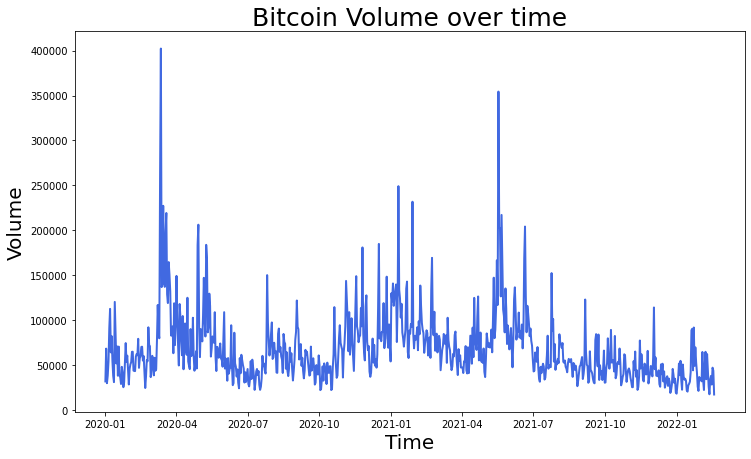

In [129]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"], bitcoin["volume"], color='royalblue', lw=2)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

In [130]:
bitcoin.isnull().sum()

datetime                     0
volume                       0
open                         0
high                         0
low                          0
close_bitcoin                0
close_eth                    0
close_bnb                    0
close_ada                    0
value_number_transaction     1
value_number_address         3
value_transaction_second     1
value_total_bitcoin         36
value_volume_trade           1
value_hash_rate              1
dtype: int64

### Linear Regression

Features - technical indicators.
Reference: https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/


In [131]:
'''
function to calculate technical indicators'''
def technical_indicator(df, column, technical_indicator, length):
    
    if technical_indicator == 'EMA':
        df.ta.ema(close = column, length = length, append = True, lookahead=False)
        
    return df
        
    

In [132]:
'''
function to calculate return'''
def calculate_return(df, columns, n):
    
    if type(columns) == list:
        for column in columns:
            df[column+'_return'] = df[column].pct_change(n)
            
    elif type(columns)==str:
        df[columns+'_return'] = df[columns].pct_change(n)
    
    return df

In [133]:

def lag_columns(df, columns, n):
    
    if type(columns) == list:
        for column in columns:
            df[column+"_"+str(n)+"_days_lagged"] = df[column].shift(periods = n)
    elif type(columns)==str:
        df[columns+"_"+str(n)+"_days_lagged"] = df[columns].shift(periods = n)
        
    return df

In [138]:
bitcoin = technical_indicator(bitcoin, 'close_bitcoin', 'EMA', length = 2)
bitcoin = lag_columns(bitcoin, ['EMA_2'], +1)
bitcoin_modified = calculate_return(bitcoin, ['close_bitcoin','EMA_2_1_days_lagged' ], 1)


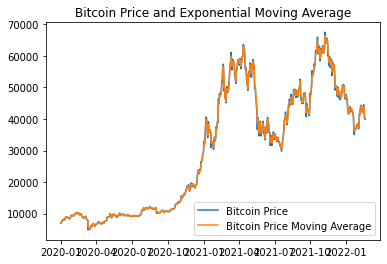

In [139]:
fig, ax = plt.subplots()

ax.plot(bitcoin['datetime'],bitcoin['close_bitcoin'], label = 'Bitcoin Price')
ax.plot(bitcoin['datetime'],bitcoin['EMA_2'], label = 'Bitcoin Price Moving Average')

plt.title("Bitcoin Price and Exponential Moving Average")
plt.legend()

# We need to lag the features to avoid leakage (lookahead bias). That is, you cannot use tomorrow's data to predict the price for tomorrow. We need to use what we know today to predict the price tomorrow.

In [145]:
bitcoin.head()

,datetime,volume,open,high,low,close_bitcoin,close_eth,close_bnb,close_ada,value_number_transaction,value_number_address,value_transaction_second,value_total_bitcoin,value_volume_trade,value_hash_rate,EMA_2,EMA_2_1_days_lagged,close_bitcoin_return,EMA_2_1_days_lagged_return
0,2020-01-01,31951.483932,7200.77,7212.50,6924.74,6965.71,127.19,13.0105,0.03269,295567.0,475461.0,3.156424,1.813287e+07,2.860097e+07,9.671772e+07,NaN,NaN,NaN,NaN
1,2020-01-02,68428.500451,6965.49,7405.00,6871.04,7344.96,134.35,13.6474,0.03417,316517.0,523231.0,2.839931,1.813465e+07,6.828297e+07,1.159241e+08,7155.335000,NaN,0.054445,NaN
2,2020-01-03,29987.974977,7345.00,7404.00,7272.21,7354.11,134.20,13.8092,0.03434,287215.0,465366.0,3.339583,1.813643e+07,1.368703e+08,1.152381e+08,7287.851667,7155.335000,0.001246,NaN
3,2020-01-04,38331.085604,7354.19,7495.00,7318.00,7358.75,135.37,14.0532,0.03460,287779.0,459065.0,3.481424,1.813822e+07,5.018183e+07,1.118084e+08,7335.117222,7287.851667,0.000631,0.018520
4,2020-01-05,54635.695316,7357.64,7795.34,7346.76,7758.00,144.15,14.9471,0.03732,299146.0,522665.0,3.192535,1.814001e+07,4.817756e+07,9.260207e+07,7617.039074,7335.117222,0.054255,0.006486


In [146]:
formula_1 = 'close_bitcoin_return ~ EMA_2_1_days_lagged_return'
res_1 = ols(formula_1, data= bitcoin).fit()

In [149]:
print(res_1.summary())

                             OLS Regression Results                             
Dep. Variable:     close_bitcoin_return   R-squared:                       0.007
Model:                              OLS   Adj. R-squared:                  0.006
Method:                   Least Squares   F-statistic:                     5.512
Date:                  Sat, 19 Feb 2022   Prob (F-statistic):             0.0191
Time:                          17:36:24   Log-Likelihood:                 1391.6
No. Observations:                   777   AIC:                            -2779.
Df Residuals:                       775   BIC:                            -2770.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
